# Annotation of scATAC-seq data with `scembed`
## Overview
A *cell embedding* is a low-dimensional representation of single-cell in an scATAC-seq workflow. Think of it as a single vector of dimensionality ~100 that summarizes the epigenetic state of a cell. Cell embeddings are useful for a variety of tasks, including visualization, clustering, and differential accessibility analysis. In this tutorial, we will learn how to use pretrained models from `scEmbed` to generate cell embeddings from scATAC-seq data. We will then use these embeddings to annotate our single-cell clusters using a reference database of embeddings with pre-generated embeddings for cells with a known cell-type.

To work with this data, we use [`scanpy`](https://github.com/scverse/scanpy) and their [`AnnData`](https://github.com/scverse/anndata) objects. These objects are a standard way of representing single-cell data in Python. We will use the `AnnData` object to represent our binary accessibility matrix and store embeddings + cell type predictions.

## Installation
First, we need to install `scEmbed`. `scEmbed` is a part of the `gitk` package. We recommend using virtual environments for this:

In [ ]:
!pip install gitk
# or if using local version:
!pip install .

## Loading Data
For this tutorial we've curated a dataset already for you to use. It comes from [10X genomics](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard). 

*Note: when using a pre-trained model, `scEmbed` requires that your `AnnData` object have `chr`, `start`, and `end` values on the `.var` attribute of the object. This is because we use interval overlap analysis to find similar regions and recast the feature-space of the new data we are embedding*.

An example of how to do this is below:

```python
import scanpy as sc
import pandas as pd

adata = sc.read_h5ad("path/to/your/data.h5ad")

peaks = pd.read_csv("/path/to/your/peaks.bed", sep="\t", header=None)
peaks.columns = ["chr", "start", "end"]
adata.var = peaks
```

**The data we are using in this example already has this completed for you.**

### Retreive preprocessed data:

In [7]:
!mkdir -p pbmc
!wget "http://big.databio.org/scembed/data/pbmc_sampled.h5ad" -O "pbmc/pbmc.h5ad"

# or use the full dataset (careful, it's 12GB!):
# !wget "http://big.databio.org/scembed/data/pbmc.h5ad" -O "pbmc/pbmc.h5ad"

--2023-05-23 15:52:17--  http://big.databio.org/scembed/data/pbmc.h5ad
Resolving big.databio.org (big.databio.org)... 128.143.223.179
Connecting to big.databio.org (big.databio.org)|128.143.223.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13570752714 (13G) [application/octet-stream]
Saving to: ‘pbmc/pbmc.h5ad’

pbmc/pbmc.h5ad      100%[===================>]  12.64G  43.5MB/s    in 5m 17s  

2023-05-23 15:57:34 (40.8 MB/s) - ‘pbmc/pbmc.h5ad’ saved [13570752714/13570752714]



## Generate embeddings using a pre-trained model
Now that we have the data, we can generate embeddings using a pre-trained model. It is imperative that the model we use for embedding generation is the same used to index the reference dataset. For this demonstration, I will use the `nleroy917/luecken2021` model that exists on the model hub. To do this, we need to:

1. Create a `PretrainedScembedModel()`
2. Project some data

If this is your first time through the tutorial, the model will need time to download. This will take a few minutes. If you've already run this tutorial, the model will be cached and this step will be much faster.

In [1]:
# read in the data
import scanpy as sc

# read in the data
pbmc = sc.read_h5ad("pbmc/pbmc.h5ad")

# this is needed since the index is weird
pbmc.obs.drop(["barcode"], inplace=True, axis=1)
pbmc.obs.reset_index(inplace=True)

In [3]:
# inspect 
pbmc

AnnData object with n_obs × n_vars = 10246 × 165434
    obs: 'barcode'
    var: 'chr', 'start', 'end'

In [4]:
# create model
from gitk.models import PretrainedScembedModel

model = PretrainedScembedModel("nleroy917/luecken2021")

In [5]:
# create embeddings (takes a few minutes)
# there will be three progress bars:
# 1. converting dataset to universe, 
# 2. creating documents, and 
# 3. projecting
embeddings = model.encode(pbmc)
pbmc.obsm['embedding'] = embeddings

100%|██████████| 165434/165434 [00:06<00:00, 27340.96it/s]
/Users/nathanleroy/uva/lab/code/gitk/venv/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 48%|████▊     | 4964/10246 [01:25<01:24, 62.21it/s]

In [29]:
# insepct the results
pbmc.obsm['embedding'].shape

(10246, 100)

## Analyzing Embeddings
Pretty fast, huh? We can now analyze the embeddings. First, let's visualize them. We'll use `umap`. We'll also color the cells by their cluster assignment. We'll use `leiden` clustering for this. This occurs in three steps:

1. `scanpy.pp.neighbors()` to compute the nearest neighbors of each cell
2. `scanpy.tl.leiden()` to compute the UMAP embedding and associated cluster assignments
3. `umap.Umap()` to compute the UMAP embedding

We can then run visualizations with seaborn and matplotlib. We'll color the cells by their cluster assignment.

In [30]:
# cluster the pbmc data
sc.pp.neighbors(pbmc, use_rep="embedding", n_neighbors=10)
sc.tl.leiden(pbmc, resolution=0.10, random_state=42)

In [31]:
import umap

reducer = umap.UMAP(n_components=2)
umap_embedding = reducer.fit_transform(pbmc.obsm['embedding'])

# attach umaps back to pbmc object
pbmc.obsm['umap'] = umap_embedding
pbmc.obs['umap1'] = umap_embedding[:, 0]
pbmc.obs['umap2'] = umap_embedding[:, 1]

Text(0, 0.5, 'UMAP 2')

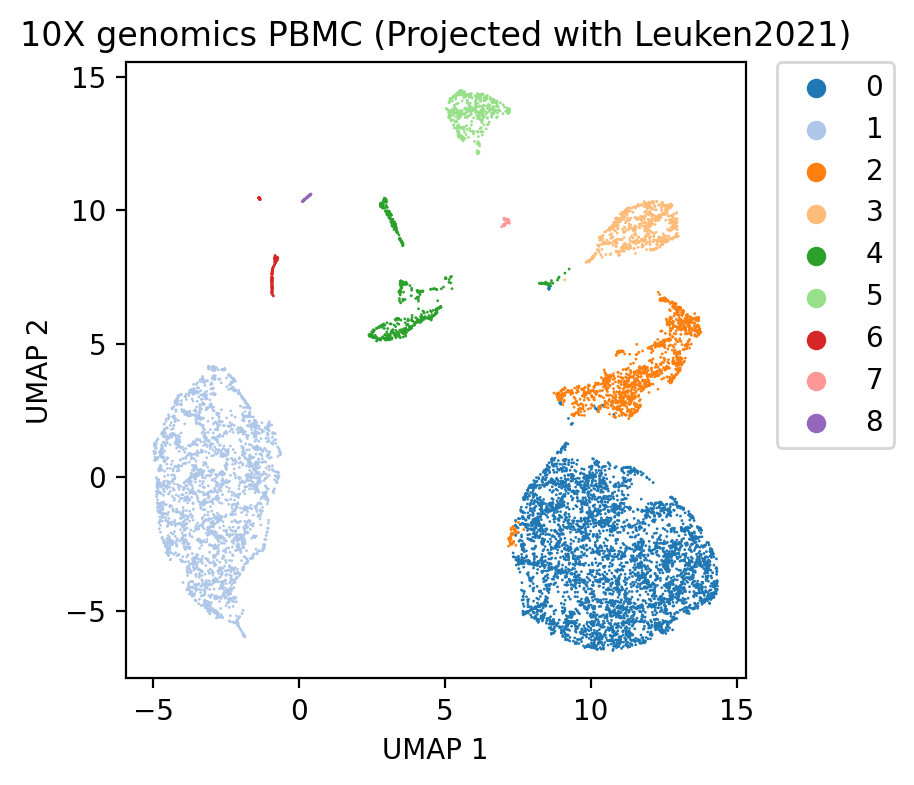

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    data=pbmc.obs,
    x='umap1',
    y='umap2',
    hue='leiden',
    palette='tab20',
    linewidth=0,
    s=1,
    ax=ax
)

# legend to upper right
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title("10X genomics PBMC (Projected with Leuken2021)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# fig.savefig("pbmc/pbmc_leucken2021_proj_leiden.pdf", bbox_inches='tight')

## Add cell type annotations
Now that we have embeddings and cell-clusters defined, we can assign putative cell-type labels to our clusters using the reference database that we have already curated. To do so, we need an `Annotator` object. This object will take our `AnnData` object and annotate the clusters with the cell-type labels. We can then visualize the results.

In [33]:
from gitk.scembed import Annotator

annotator = Annotator(
    location="http://localhost:6333",
    collection_name="leucken2021",
)

In [43]:
# annotate the data
annotator.annotate(pbmc)

100%|██████████| 10246/10246 [01:22<00:00, 124.80it/s]


In [40]:
# print table of leiden cluster with cell type predictions
pbmc.obs[['leiden', 'pred_celltype']].drop_duplicates().sort_values(by="leiden")

# create cluster to cell type mapping
cluster_to_celltype = pbmc.obs[['leiden', 'pred_celltype']].drop_duplicates().set_index('leiden').to_dict()['pred_celltype']

In [41]:
cluster_to_celltype

{'1': 'CD14+ Mono',
 '0': 'CD4+ T activated',
 '5': 'Naive CD20+ B',
 '2': 'CD4+ T activated',
 '3': 'NK',
 '4': 'CD14+ Mono',
 '7': 'Naive CD20+ B',
 '6': 'CD14+ Mono',
 '8': 'CD14+ Mono'}

Text(0, 0.5, 'UMAP 2')

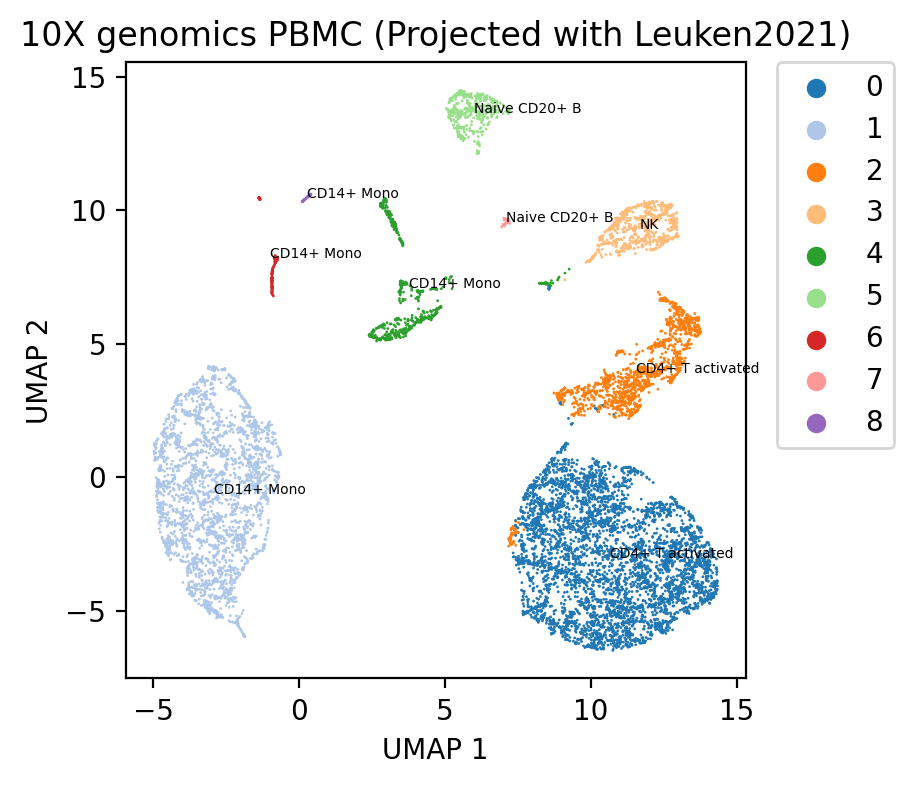

In [42]:
# plot each cluster and annotate with cell type
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    data=pbmc.obs,
    x='umap1',
    y='umap2',
    hue='leiden',
    palette='tab20',
    linewidth=0,
    s=1,
    ax=ax
)

# legend to upper right
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# add a label to the plot for each cluster
for cluster, celltype in cluster_to_celltype.items():
    # get the centroid of the cluster
    centroid = pbmc.obs.query(f"leiden == '{cluster}'")[['umap1', 'umap2']].mean()

    ax.text(centroid['umap1'], centroid['umap2'], celltype, fontsize=5)

ax.set_title("10X genomics PBMC (Projected with Leuken2021)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")


    